In [1]:
# Cellule 1 – Imports, GPU, config, chemins

# ============================================================
# Notebook 04 — BoneAge Regression V12 (preprocessed_v3)
# Deux phases : Head → Fine-tuning partiel (30 couches)
# ============================================================

import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.utils.class_weight import compute_sample_weight

from tensorflow.keras import layers, models, callbacks, mixed_precision, Input
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.optimizers import AdamW

# ----------------- Seed & GPU -----------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Seed global fixé à 42.")

print("\n--- Configuration GPU et Mixed Precision ---")
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)
print("Politique de précision mixte :", mixed_precision.global_policy())

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU détecté ({len(gpus)}) — croissance mémoire activée.")
else:
    print("Aucun GPU détecté → CPU")

print("TensorFlow:", tf.__version__)

# ----------------- Paramètres globaux -----------------
IMG_SIZE = 300
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

BASE_DIR = Path(".")  # Notebook lancé depuis le dossier Boneage

# Dossier des images prétraitées (preprocessed_v3)
PREPROC_DIR = BASE_DIR / "preprocessed_v3"

# CSV v3
TRAIN_CSV = BASE_DIR / "boneage_train_final_v3.csv"
VAL_CSV   = BASE_DIR / "boneage_val_v3.csv"
TEST_CSV  = BASE_DIR / "boneage_test_v3.csv"

# Noms de sortie pour V12
FINETUNED_WEIGHTS_PATH = "best_finetuned_v12_preproc_v3.weights.h5"
MODEL_V12_PATH         = "model_v12_preproc_v3.keras"

print("\n=== MODE V12_preprocessed_v3 ===")
print("Images prétraitées :", PREPROC_DIR)
print("Train CSV :", TRAIN_CSV)
print("Val   CSV :", VAL_CSV)
print("Test  CSV :", TEST_CSV)
print("Poids fine-tuned :", FINETUNED_WEIGHTS_PATH)
print("Modèle complet :", MODEL_V12_PATH)


2025-11-30 01:03:26.226756: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 01:03:26.335542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-30 01:03:26.360339: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-30 01:03:26.369035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-30 01:03:26.464241: I tensorflow/core/platform/cpu_feature_guar

Seed global fixé à 42.

--- Configuration GPU et Mixed Precision ---
Politique de précision mixte : <DTypePolicy "mixed_float16">
GPU détecté (1) — croissance mémoire activée.
TensorFlow: 2.17.0

=== MODE V12_preprocessed_v3 ===
Images prétraitées : preprocessed_v3
Train CSV : boneage_train_final_v3.csv
Val   CSV : boneage_val_v3.csv
Test  CSV : boneage_test_v3.csv
Poids fine-tuned : best_finetuned_v12_preproc_v3.weights.h5
Modèle complet : model_v12_preproc_v3.keras


I0000 00:00:1764464609.378277   91645 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764464609.739862   91645 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764464609.740133   91645 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# Cellule 2 – Chargement des DataFrames + préparation des chemins

# ============================================================
# CELLULE 2 — DataFrames (V12, images prétraitées)
# ============================================================

def prepare_dataframe(df, images_dir: Path):
    # On suppose que l'ID correspond à <id>.png dans preprocessed_v3
    df = df.copy()
    df["image_path"] = df["id"].apply(lambda x: str(images_dir / f"{x}.png"))
    # On filtre les lignes dont l'image n'existe pas
    df = df[df["image_path"].apply(lambda x: Path(x).exists())]
    df["male"]  = df["male"].astype(np.float32)
    df["label"] = df["boneage"].astype(np.float32)
    return df

print("\n--- Chargement des CSV ---")
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)

train_df = prepare_dataframe(train_df, PREPROC_DIR)
val_df   = prepare_dataframe(val_df, PREPROC_DIR)
test_df  = prepare_dataframe(test_df, PREPROC_DIR)

# Sample weights (équilibrage sur 'male')
sample_weights = compute_sample_weight(class_weight="balanced",
                                       y=train_df["male"])
train_df["sample_weight"] = sample_weights
val_df["sample_weight"]   = 1.0
test_df["sample_weight"]  = 1.0

print(f"Train : {len(train_df)}  |  Val : {len(val_df)}  |  Test : {len(test_df)}")
print("Exemple de lignes train_df :")
train_df.head()



--- Chargement des CSV ---
Train : 7701  |  Val : 1359  |  Test : 2265
Exemple de lignes train_df :


,id,boneage,male,age_bin,strata,image_path,label,sample_weight
0,12380,156,1.0,144-161,True_144-161,preprocessed_v3/12380.png,156.0,0.927608
1,9535,120,0.0,108-125,False_108-125,preprocessed_v3/9535.png,120.0,1.084648
2,12319,106,0.0,90-107,False_90-107,preprocessed_v3/12319.png,106.0,1.084648
3,10433,94,0.0,90-107,False_90-107,preprocessed_v3/10433.png,94.0,1.084648
4,9223,82,0.0,72-89,False_72-89,preprocessed_v3/9223.png,82.0,1.084648


In [3]:
# Cellule 3 – Pipeline tf.data (chargement PNG, augmentations, datasets)

# ============================================================
# CELLULE 3 — Pipelines TF (V12, préprocessed_v3)
# ============================================================

print("\n--- Construction Pipeline TF (V12_preprocessed_v3) ---")

# Augmentations fortes (adaptées aux images déjà segmentées + CLAHE)
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.40),             # ±40°
        layers.RandomTranslation(0.20, 0.20),    # ±20%
        layers.RandomZoom(0.40),                 # jusqu'à 40%
        layers.RandomBrightness(0.40),
        layers.RandomContrast(0.40),
        layers.GaussianNoise(0.08),
        layers.RandomCrop(230, 230),
        layers.Resizing(IMG_SIZE, IMG_SIZE),
        layers.RandomRotation(factor=0.01)       # petite distorsion
    ],
    name="data_augmentation_v12_stronger"
)

def load_and_preprocess(path, sex, label, augment=False):
    # Chargement PNG (grayscale) → RGB
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_png(img_bytes, channels=1)
    img = tf.image.grayscale_to_rgb(img)

    # Les images sont déjà à IMG_SIZE, mais on force la taille par sécurité
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    if augment:
        img = data_augmentation(img, training=True)

    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)  # Normalisation compatible EfficientNetV2

    sex = tf.reshape(tf.cast(sex, tf.float32), (1,))
    label = tf.reshape(tf.cast(label, tf.float32), (1,))

    return {"image_input": img, "sex_input": sex}, label

def create_dataset(df, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices(
        (
            df["image_path"].values,
            df["male"].values,
            df["label"].values,
            df["sample_weight"].values
        )
    )

    if shuffle:
        ds = ds.shuffle(len(df), reshuffle_each_iteration=True)

    ds = ds.map(
        lambda p, s, l, w: (*load_and_preprocess(p, s, l, augment), w),
        num_parallel_calls=AUTOTUNE
    )

    # Keras interprète (x, y, w) comme (inputs, label, sample_weight)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = create_dataset(train_df, shuffle=True, augment=True)
val_ds   = create_dataset(val_df,   shuffle=False, augment=False)
test_ds  = create_dataset(test_df,  shuffle=False, augment=False)

print("Pipelines V12_preprocessed_v3 prêts.")



--- Construction Pipeline TF (V12_preprocessed_v3) ---


I0000 00:00:1764464747.020621   91645 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764464747.020761   91645 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764464747.020814   91645 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764464747.181319   91645 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764464747.181448   91645 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-30

Pipelines V12_preprocessed_v3 prêts.


In [4]:
# Cellule 4 – Construction du modèle (backbone + tête)

# ============================================================
# CELLULE 4 — Construction du modèle V12
# ============================================================

print("\n--- Construction du modèle V12 (EfficientNetV2B3) ---")

# Backbone EfficientNetV2B3
base_model = EfficientNetV2B3(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Geler les BatchNorm (ON LES LAISSE TOUJOURS GELÉS)
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Phase 1 : HEAD uniquement → backbone gelé
base_model.trainable = False

# Inputs
image_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image_input")
sex_input   = Input(shape=(1,), name="sex_input")

# Tête du modèle
x = base_model(image_input, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.concatenate([x, sex_input])

x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization(trainable=False)(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation="relu")(x)

output = layers.Dense(1, dtype="float32")(x)

model = models.Model(
    inputs=[image_input, sex_input],
    outputs=output,
    name="boneage_regression_v12_preprocessed_v3"
)

# Compilation phase 1 (HEAD)
optimizer_head = AdamW(learning_rate=1e-3)

model.compile(
    optimizer=optimizer_head,
    loss="mean_absolute_error",
    metrics=["mean_absolute_error"]
)

print("\nRésumé du modèle V12 (phase HEAD) :")
model.summary()



--- Construction du modèle V12 (EfficientNetV2B3) ---


2025-11-30 01:06:41.551885: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.



Résumé du modèle V12 (phase HEAD) :


Model: "boneage_regression_v12_preprocessed_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b3   │ (None, 10, 10,    │ 12,930,622 │ image_input[0][0] │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1536)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sex_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1537)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ sex_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    393,728 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,358,399 (50.96 MB)

 Trainable params: 426,753 (1.63 MB)

 Non-trainable params: 12,931,646 (49.33 MB)

In [5]:
# Cellule 5 – Phase 1 : entraînement de la tête uniquement

# ============================================================
# CELLULE 5 — Phase 1 : Entraînement de la tête (backbone gelé)
# ============================================================

print("\n--- Phase 1 : Entraînement de la tête (backbone gelé) ---")

EPOCHS_HEAD = 5  # suffisant pour stabiliser la tête

callbacks_head = [
    callbacks.EarlyStopping(
        monitor="val_mean_absolute_error",
        patience=3,
        restore_best_weights=True,
        mode="min",
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_mean_absolute_error",
        factor=0.3,
        patience=2,
        min_lr=1e-5,
        mode="min",
        verbose=1
    )
]

history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks_head
)

print("Phase 1 terminée.")



--- Phase 1 : Entraînement de la tête (backbone gelé) ---
Epoch 1/5


I0000 00:00:1764465254.221973   91753 service.cc:146] XLA service 0x7d5704004140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764465254.222016   91753 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-30 01:14:14.688696: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-30 01:14:16.086811: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 91200
I0000 00:00:1764465269.940563   91753 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


963/963 ━━━━━━━━━━━━━━━━━━━━ 120s 97ms/step - loss: 27.9263 - mean_absolute_error: 27.9862 - val_loss: 20.3516 - val_mean_absolute_error: 20.3516 - learning_rate: 0.0010
Epoch 2/5
963/963 ━━━━━━━━━━━━━━━━━━━━ 61s 63ms/step - loss: 23.3550 - mean_absolute_error: 23.4056 - val_loss: 20.7789 - val_mean_absolute_error: 20.7789 - learning_rate: 0.0010
Epoch 3/5
963/963 ━━━━━━━━━━━━━━━━━━━━ 63s 66ms/step - loss: 22.8726 - mean_absolute_error: 22.9198 - val_loss: 17.9014 - val_mean_absolute_error: 17.9014 - learning_rate: 0.0010
Epoch 4/5
963/963 ━━━━━━━━━━━━━━━━━━━━ 65s 67ms/step - loss: 22.9152 - mean_absolute_error: 22.9483 - val_loss: 18.8105 - val_mean_absolute_error: 18.8105 - learning_rate: 0.0010
Epoch 5/5
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 22.4827 - mean_absolute_error: 22.5366
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
963/963 ━━━━━━━━━━━━━━━━━━━━ 65s 67ms/step - loss: 22.2863 - mean_absolute_error: 22.3197 - val_loss: 18.3143 - val_me

In [9]:
# ============================================================
# CELLULE 6 — Phase 2 : Préparation du fine-tuning partiel (30 couches)
# Version robuste avec WarmUp compatible LossScaleOptimizer
# ============================================================

print("\n--- Phase 2 : Préparation du fine-tuning partiel (30 couches) ---")

# On dégèle le backbone
base_model.trainable = True

fine_tune_layers = 30
total_layers = len(base_model.layers)
freeze_until = max(0, total_layers - fine_tune_layers)

for i, layer in enumerate(base_model.layers):
    if i < freeze_until:
        layer.trainable = False
    else:
        # même en fine-tuning, BN restent gelées car dataset médical
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True

print(f"Total layers backbone : {total_layers}")
print(f"Couches gelées     : 0 → {freeze_until-1}")
print(f"Couches fine-tunées: {freeze_until} → {total_layers-1}")

# Optimiseur pour la phase FT
initial_lr = 1e-5
optimizer_ft = AdamW(learning_rate=initial_lr)


class WarmUpLearningRate(callbacks.Callback):
    """Warmup LR compatible avec LossScaleOptimizer / mixed precision."""

    def __init__(self, warmup_schedule):
        super().__init__()
        self.warmup_schedule = warmup_schedule

    def _get_lr_variable(self):
        """
        Récupère la tf.Variable du learning rate en gérant les wrappers
        (LossScaleOptimizer, etc.).
        """
        opt = self.model.optimizer

        # Déballer l'optimizer interne si possible
        for attr in ["inner_optimizer", "_optimizer", "optimizer"]:
            if hasattr(opt, attr):
                opt = getattr(opt, attr)
                break

        # Chercher lr ou learning_rate
        if hasattr(opt, "lr"):
            return opt.lr
        if hasattr(opt, "learning_rate"):
            return opt.learning_rate

        return None

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.warmup_schedule:
            new_lr = self.warmup_schedule[epoch]
            lr_var = self._get_lr_variable()
            if lr_var is not None:
                lr_var.assign(new_lr)
                print(f"\n[WarmUp] Epoch {epoch}: LR → {new_lr:.2e}")
            else:
                print("\n[WarmUp] Impossible de mettre à jour le LR (variable introuvable).")

    def on_epoch_end(self, epoch, logs=None):
        lr_var = self._get_lr_variable()
        if lr_var is not None:
            lr_val = float(tf.keras.backend.get_value(lr_var))
            print(f"[DEBUG] LR (fin epoch {epoch}) : {lr_val:.2e}")
        else:
            print(f"[DEBUG] LR (fin epoch {epoch}) : introuvable.")


warmup_schedule = {
    0: 2e-6,
    1: 5e-6,
    2: 1e-5
}

warmup_cb = WarmUpLearningRate(warmup_schedule)

# Re-compile le modèle pour la phase FT
model.compile(
    optimizer=optimizer_ft,
    loss="mean_absolute_error",
    metrics=["mean_absolute_error"]
)

callbacks_ft = [
    warmup_cb,
    callbacks.EarlyStopping(
        monitor="val_mean_absolute_error",
        patience=5,
        restore_best_weights=True,
        mode="min",
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_mean_absolute_error",
        factor=0.3,
        patience=2,
        min_lr=1e-7,
        mode="min",
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=FINETUNED_WEIGHTS_PATH,
        monitor="val_mean_absolute_error",
        save_weights_only=True,
        save_best_only=True,
        mode="min",
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=MODEL_V12_PATH,
        monitor="val_mean_absolute_error",
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        verbose=1
    )
]

print("Recompilation OK pour le fine-tuning (V12).")



--- Phase 2 : Préparation du fine-tuning partiel (30 couches) ---
Total layers backbone : 409
Couches gelées     : 0 → 378
Couches fine-tunées: 379 → 408
Recompilation OK pour le fine-tuning (V12).


In [10]:
# ============================================================
# CELLULE 7 — Phase 2 : Fine-tuning partiel 
# ============================================================

print("\n--- Phase 2 : Lancement du fine-tuning V12 ---")

EPOCHS_FT = 30  # EarlyStopping arrêtera avant si nécessaire

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FT,
    callbacks=callbacks_ft,
    verbose=1
)

print("\nFine-tuning terminé.")



--- Phase 2 : Lancement du fine-tuning V12 ---

[WarmUp] Epoch 0: LR → 2.00e-06
Epoch 1/30
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 22.1954 - mean_absolute_error: 22.2893[DEBUG] LR (fin epoch 0) : 2.00e-06

Epoch 1: val_mean_absolute_error improved from None to 17.88698, saving model to best_finetuned_v12_preproc_v3.weights.h5

Epoch 1: val_mean_absolute_error improved from None to 17.88698, saving model to model_v12_preproc_v3.keras
963/963 ━━━━━━━━━━━━━━━━━━━━ 123s 101ms/step - loss: 21.9663 - mean_absolute_error: 22.0240 - val_loss: 17.8870 - val_mean_absolute_error: 17.8870 - learning_rate: 2.0000e-06

[WarmUp] Epoch 1: LR → 5.00e-06
Epoch 2/30
962/963 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 20.9223 - mean_absolute_error: 20.9570[DEBUG] LR (fin epoch 1) : 5.00e-06

Epoch 2: val_mean_absolute_error improved from 17.88698 to 17.77240, saving model to best_finetuned_v12_preproc_v3.weights.h5

Epoch 2: val_mean_absolute_error improved from 17.88698 to 17.77240, saving model

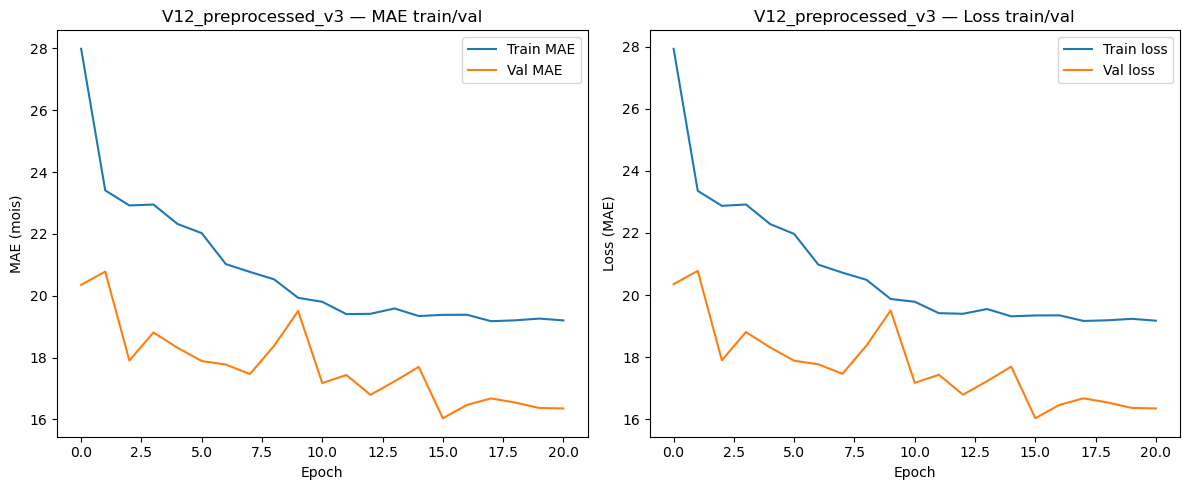

In [11]:
# Cellule 8 – Courbes d’apprentissage (MAE / loss)

# ============================================================
# CELLULE 8 — Courbes d'apprentissage
# ============================================================

# Fusion des historiques (optionnel)
def merge_histories(h1, h2):
    merged = {}
    for k in h1.history.keys():
        merged[k] = h1.history[k] + h2.history.get(k, [])
    return merged

history_combined = merge_histories(history_head, history_ft)

plt.figure(figsize=(12, 5))

# MAE
plt.subplot(1, 2, 1)
plt.plot(history_combined["mean_absolute_error"], label="Train MAE")
plt.plot(history_combined["val_mean_absolute_error"], label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE (mois)")
plt.title("V12_preprocessed_v3 — MAE train/val")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_combined["loss"], label="Train loss")
plt.plot(history_combined["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.title("V12_preprocessed_v3 — Loss train/val")
plt.legend()

plt.tight_layout()
plt.show()



--- Évaluation finale du modèle V12_preprocessed_v3 ---
Poids V12 chargés : best_finetuned_v12_preproc_v3.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 15.6031 - mean_absolute_error: 15.6031

MAE test (Keras) : 15.603 mois

Calcul des prédictions et du R² sur le test ...
284/284 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step
R² sur le test : 0.754


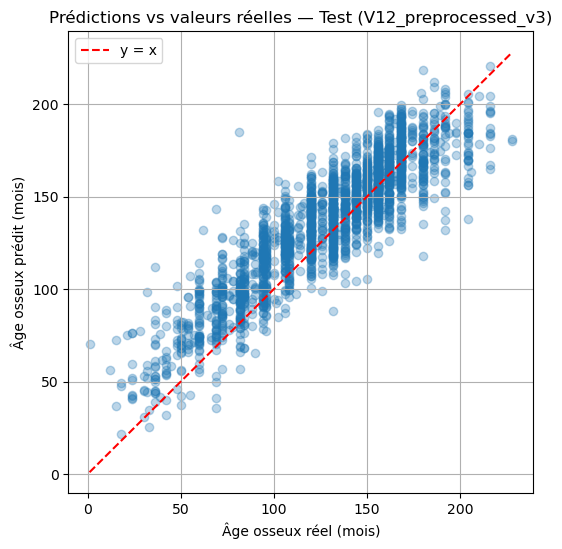

In [12]:
# Cellule 9 – Évaluation finale sur le test

# ============================================================
# CELLULE 9 — Évaluation finale sur le test
# ============================================================

print("\n--- Évaluation finale du modèle V12_preprocessed_v3 ---")

# Charger les meilleurs poids sauvegardés
model.load_weights(FINETUNED_WEIGHTS_PATH)
print(f"Poids V12 chargés : {FINETUNED_WEIGHTS_PATH}")

# 1) MAE test (via Keras)
test_loss, test_mae = model.evaluate(test_ds, verbose=1)
print(f"\nMAE test (Keras) : {test_mae:.3f} mois")

# 2) Prédictions + R²
print("\nCalcul des prédictions et du R² sur le test ...")
y_true = test_df["label"].values
y_pred = model.predict(test_ds).flatten()

r2 = r2_score(y_true, y_pred)
print(f"R² sur le test : {r2:.3f}")

# 3) Scatterplot True vs Pred
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot(
    [y_true.min(), y_true.max()],
    [y_true.min(), y_true.max()],
    "r--",
    label="y = x"
)

plt.xlabel("Âge osseux réel (mois)")
plt.ylabel("Âge osseux prédit (mois)")
plt.title("Prédictions vs valeurs réelles — Test (V12_preprocessed_v3)")
plt.legend()
plt.grid(True)
plt.show()
